# MLE Analysis of externally simulated IBD data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import socket as socket
import os as os
import sys as sys
import itertools as it
import multiprocessing as mp

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("bionc"):
    print("Leipzig Cluster detected!")
    path = "/mnt/archgen/users/hringbauer/git/IBD-Analysis/ibd_analysis/blocksim/" # Update if another cluster / setup!
    sys.path.insert(0, path) # Work in blocksim  Path
os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd()) 
print("CPU Count: %d" % mp.cpu_count())


### Import the MLE Analysis Object
sys.path.append('../analysis_popres/')
from mle_multi_run import MLE_analyse  # @UnresolvedImport

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

bionc21
Leipzig Cluster detected!
/mnt/archgen/users/hringbauer/git/IBD-Analysis/ibd_analysis/blocksim
CPU Count: 40


# Test Loading Data from Raphael

In [2]:
df_ibds = pd.read_csv("./Data/ext_raphael/IBD_segments.csv", index_col=0)
df_iids = pd.read_csv("./Data/ext_raphael/sample_locations.csv", index_col=0)
print("Loaded %i IBDs" % (len(df_ibds)))
print("Loaded %i IIDs" % (len(df_iids)))
m = np.max(df_ibds["endpoint"])
print("Highest IBD End Point: %.4f cm" % m)

Loaded 393 IBDs
Loaded 50 IIDs
Highest IBD End Point: 49.9462 cm


## Plot Sample Positions

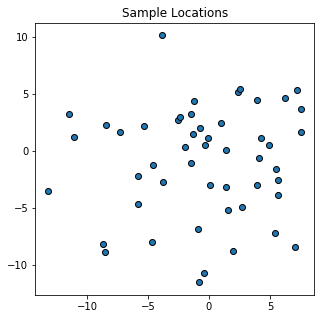

In [3]:
fig = plt.figure(figsize=(5,5))
ax = plt.gca()
ax.scatter(df_iids["x"], df_iids["y"], edgecolor="k")
ax.set_title("Sample Locations")
plt.show()

In [8]:
df_ibds.head()

,individual1,individual2,start,endpoint,length
0,35,43,30.501047,30.597640,0.096592
1,35,43,43.255314,43.669920,0.414607
2,1,10,6.765293,6.814625,0.049332
3,31,22,32.919503,33.028224,0.108721
4,31,22,48.577710,49.054887,0.477177


## 1) Do MLE inference

### Get the Input for MLE Object:
pair_dist, pair_IBD, pair_nr, position_lis




In [6]:
def pw_dist(x,y):
    """Return pw. distance between two locations"""
    d = np.sqrt(np.sum((x-y)**2))
    return d

def get_mle_object(df_iids, df_ibds):
    """Create and return MLE object given IID Dataframe and pw. IBD Dataframe.
    Return MLE_analyse object.
    df_iids: Dataframe of indivdiuals, with x and y coordinates
    df_ibds: Dataframe of IBD segments, with length, indivdiual 1 and indivdiual 2.
    Has to match df_iids"""

    start_list = df_iids[["x", "y"]].values
    l = len(start_list) 

    ### Create IBD Vectors
    n_pairs = (l * (l - 1) / 2)  # List of IBD-blocks per pair
    pair_IBD = [[] for _ in range(n_pairs)]  # Initialize with empty lists
    pair_nr = np.ones(n_pairs)
    assert(np.min(pair_nr) >= 1)  # Sanity Check

    # Get distance Array of all blocks
    pair_dist = [pw_dist(start_list[i], start_list[j]) for i in range(l) for j in range(i)]

    ### Get IBD Segments
    for _, row in df_ibds.iterrows():
        ibd_length = row["length"] * 100  # Get length in centiMorgan
        ind1 = int(row["individual1"])
        ind2 = int(row["individual2"])
        j, i = min(ind1, ind2), max(ind1, ind2) 
        if i != j:
            pair_IBD[(i * (i - 1)) / 2 + j].append(ibd_length)  # Append an IBD-block  

    assert(len(pair_dist) == len(pair_IBD))  # Sanity Check
    assert(len(pair_dist) == len(pair_nr))

    pair_dist, pair_IBD, pair_nr = np.array(pair_dist), np.array(pair_IBD), np.array(pair_nr)  # Make everything a Numpy array.
    mle_analyze = MLE_analyse(0, pair_dist, pair_IBD, pair_nr, position_list=start_list, error_model=False)
    return mle_analyze

def run_mle_analyze(df_iids, df_ibds, model="hetero",
                    start_params=[150, 150, 0.5, 0.5, 0.5], 
                    g=50.0, barrier_pos=0):
    """Load and run Inference for df_idds and df_ibds.
    g: Chromosome Length (in Morgan)"""
    
    mle_analyze = get_mle_object(df_iids, df_ibds) # Create MLE Objec
    
    mle_analyze.create_mle_model_barrier(model=model, g=g, start_param=np.array(start_params), 
                             diploid=False, barrier_pos=barrier_pos,
                             step=0, L=0, mm_mode="isotropic")
    mle_analyze.mle_analysis_error() 

# 1) Estimate Parameters Scenario I (sym.)

In [ ]:
df_ibds = pd.read_csv("./Data/ext_raphael/IBD_segments.csv", index_col=0)
df_iids = pd.read_csv("./Data/ext_raphael/sample_locations.csv", index_col=0)

run_mle_analyze(df_iids, df_ibds, start_params=[1.0, 1.0, 1.0, 1.0], g=50.0, barrier_pos=0)

Total Block Nr. for Analysis: 393
Initializing MLE-Object with Start Parameters: 
[1. 1. 1. 1.]
Barrier Pos.:
0
Barrier Angle:
0
Transformed Position List:
[[ -5.82912921  -4.67445992]
 [  7.07038644  -8.4423387 ]
 [  0.06513592  -2.98053752]
 [  1.57548745  -5.14306975]
 [ -3.89031662  10.15537458]
 [  4.30291387   1.13683077]
 [-13.20354892  -3.47898349]
 [  4.09135239  -0.62420307]
 [  1.41611244   0.08625373]
 [  4.94260251   0.49670385]
 [  5.37878759  -7.17506993]
 [  5.68284412  -2.57624694]
 [ -0.81862308 -11.52774606]
 [ -7.29829195   1.64725146]
 [  2.38350293   5.21961192]
 [ -1.49619143  -1.03205167]
 [  1.40837584  -3.16669268]
 [ -1.50136068   3.22826246]
 [ -0.09794825   1.10919691]
 [  2.67305958  -4.94694248]
 [  7.19956268   5.37573135]
 [ -5.3227383    2.24436829]
 [-11.47915088   3.25904894]
 [ -8.43382853   2.27437611]
 [ -4.61311513  -1.18805603]
 [  5.66756283  -3.83105303]
 [  2.57546448   5.48490253]
 [ -1.97329914   0.34887762]
 [ -8.53048408  -8.87109711]
 [ 

/usr/local/lib/python2.7/dist-packages/scipy/sparse/compressed.py:708: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self[i, j] = values


Time for calculation: 18.6624
Total log likelihood: -2483.8001
nl: 1.0500
nr: 1.0000
sigma_l: 1.0000
sigma_r: 1.0000
beta: 0.0000
Time for calculation: 18.6441
Total log likelihood: -2488.4380
nl: 1.0000
nr: 1.0500
sigma_l: 1.0000
sigma_r: 1.0000
beta: 0.0000
Time for calculation: 18.4957
Total log likelihood: -2489.3885
nl: 1.0000
nr: 1.0000
sigma_l: 1.0500
sigma_r: 1.0000
beta: 0.0000
Time for calculation: 22.1095
Total log likelihood: -2486.7669
nl: 1.0000
nr: 1.0000
sigma_l: 1.0000
sigma_r: 1.0500
beta: 0.0000
Time for calculation: 22.0207
Total log likelihood: -2488.0278
nl: 1.0250
nr: 0.9500
sigma_l: 1.0250
sigma_r: 1.0250
beta: 0.0000
Time for calculation: 22.2020
Total log likelihood: -2482.4805
nl: 1.0375
nr: 0.9000
sigma_l: 1.0375
sigma_r: 1.0375
beta: 0.0000
Time for calculation: 22.0649
Total log likelihood: -2476.5189
nl: 0.9687
nr: 0.9500
sigma_l: 1.0437
sigma_r: 1.0437
beta: 0.0000
Time for calculation: 22.7015
Total log likelihood: -2480.3542
nl: 1.0031
nr: 0.9250
sigma

../analysis_popres/hetero_sharing.py:49: RuntimeWarning: overflow encountered in multiply
  density += np.multiply(coalescence.toarray(), blocks[:, np.newaxis, np.newaxis])  # multiply the two
../analysis_popres/hetero_sharing.py:49: RuntimeWarning: overflow encountered in add
  density += np.multiply(coalescence.toarray(), blocks[:, np.newaxis, np.newaxis])  # multiply the two
../analysis_popres/hetero_sharing.py:49: RuntimeWarning: invalid value encountered in add
  density += np.multiply(coalescence.toarray(), blocks[:, np.newaxis, np.newaxis])  # multiply the two


Time for calculation: 35.9777
Total log likelihood: nan
nl: 1.0545
nr: 0.3303
sigma_l: 1.1287
sigma_r: 1.2699
beta: 0.0000


../analysis_popres/mle_estim_error.py:470: RuntimeWarning: invalid value encountered in double_scalars
  ll = l1 + log_pr_no_shr
../analysis_popres/mle_estim_error.py:468: RuntimeWarning: invalid value encountered in log
  l1 = np.sum(np.log(shr_pr[indices]))
/home/harald_ringbauer/.local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/harald_ringbauer/.local/lib/python2.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


Time for calculation: 35.6937
Total log likelihood: -2404.2973
nl: 1.1245
nr: 0.1690
sigma_l: 1.0881
sigma_r: 1.3078
beta: 0.0000
Time for calculation: 41.6794
Total log likelihood: nan
nl: 1.0403
nr: 0.5708
sigma_l: 1.1104
sigma_r: 1.1477
beta: 0.0000
Time for calculation: 26.2928
Total log likelihood: -2407.9422
nl: 1.0964
nr: 0.3029
sigma_l: 1.0955
sigma_r: 1.2544
beta: 0.0000
Time for calculation: 35.8809
Total log likelihood: -2420.8637
nl: 1.0544
nr: 0.5038
sigma_l: 1.1067
sigma_r: 1.1744
beta: 0.0000
Time for calculation: 30.7372
Total log likelihood: -2395.9514
nl: 1.0823
nr: 0.6300
sigma_l: 1.0662
sigma_r: 1.0845
beta: 0.0000
Time for calculation: 26.3804
Total log likelihood: -2417.7992
nl: 1.0614
nr: 0.4053
sigma_l: 1.1131
sigma_r: 1.2235
beta: 0.0000
Time for calculation: 30.8116
Total log likelihood: -2391.1949
nl: 1.0440
nr: 0.3758
sigma_l: 1.1814
sigma_r: 1.1791
beta: 0.0000
Time for calculation: 30.7273
Total log likelihood: -2390.2398
nl: 1.0667
nr: 0.3328
sigma_l: 1.1

# 2) Estimate Parameters Scenario II (het.)

In [ ]:
df_ibds = pd.read_csv("./Data/ext_raphael/IBD_segments_heter.csv", index_col=0)
df_iids = pd.read_csv("./Data/ext_raphael/sample_locations_hetero.csv", index_col=0)

run_mle_analyze(df_iids, df_ibds, start_params=[1.0, 1.0, 1.0, 1.0], g=50.0, barrier_pos=0)

## For debugging: Run seperate Estimates

In [11]:
mle_analyze = get_mle_object(df_iids, df_ibds)

Total Block Nr. for Analysis: 393


In [15]:
mle_analyze.create_mle_model("hetero", g=50.0, start_param=np.array([150, 150, 0.5, 0.5, 0.5]), 
                             diploid=False, barrier_pos=0,
                             step=0, L=0, mm_mode="isotropic")

Initializing MLE-Object with Start Parameters: 
[150.  150.    0.5   0.5   0.5]
Barrier Pos.:
0
Barrier Angle:
0
Transformed Position List:
[[ -5.82912921  -4.67445992]
 [  7.07038644  -8.4423387 ]
 [  0.06513592  -2.98053752]
 [  1.57548745  -5.14306975]
 [ -3.89031662  10.15537458]
 [  4.30291387   1.13683077]
 [-13.20354892  -3.47898349]
 [  4.09135239  -0.62420307]
 [  1.41611244   0.08625373]
 [  4.94260251   0.49670385]
 [  5.37878759  -7.17506993]
 [  5.68284412  -2.57624694]
 [ -0.81862308 -11.52774606]
 [ -7.29829195   1.64725146]
 [  2.38350293   5.21961192]
 [ -1.49619143  -1.03205167]
 [  1.40837584  -3.16669268]
 [ -1.50136068   3.22826246]
 [ -0.09794825   1.10919691]
 [  2.67305958  -4.94694248]
 [  7.19956268   5.37573135]
 [ -5.3227383    2.24436829]
 [-11.47915088   3.25904894]
 [ -8.43382853   2.27437611]
 [ -4.61311513  -1.18805603]
 [  5.66756283  -3.83105303]
 [  2.57546448   5.48490253]
 [ -1.97329914   0.34887762]
 [ -8.53048408  -8.87109711]
 [  0.98284028   2.

0

In [16]:
mle_analyze.mle_analysis_error()  # Analyses the samples

Doing fit...
nl: 150.0000
nr: 150.0000
sigma_l: 0.5000
sigma_r: 0.5000
beta: 0.5000


/usr/local/lib/python2.7/dist-packages/scipy/sparse/compressed.py:708: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self[i, j] = values


Time for calculation: 7.0778
Total log likelihood: -3660.5979
nl: 157.5000
nr: 150.0000
sigma_l: 0.5000
sigma_r: 0.5000
beta: 0.5000
Time for calculation: 7.0193
Total log likelihood: -3668.0701
nl: 150.0000
nr: 157.5000
sigma_l: 0.5000
sigma_r: 0.5000
beta: 0.5000
Time for calculation: 7.0212
Total log likelihood: -3670.1536
nl: 150.0000
nr: 150.0000
sigma_l: 0.5250
sigma_r: 0.5000
beta: 0.5000
Time for calculation: 6.9204
Total log likelihood: -3651.9043
nl: 150.0000
nr: 150.0000
sigma_l: 0.5000
sigma_r: 0.5250
beta: 0.5000
Time for calculation: 6.8794
Total log likelihood: -3652.4011
nl: 150.0000
nr: 150.0000
sigma_l: 0.5000
sigma_r: 0.5000
beta: 0.5250
Time for calculation: 7.1036
Total log likelihood: -3630.3344
nl: 153.0000
nr: 142.5000
sigma_l: 0.5100
sigma_r: 0.5100
beta: 0.5100
Time for calculation: 7.0177
Total log likelihood: -3632.9760
nl: 143.7000
nr: 147.0000
sigma_l: 0.5140
sigma_r: 0.5140
beta: 0.5140
Time for calculation: 7.0834
Total log likelihood: -3622.5656
nl: 136

KeyboardInterrupt: 

In [ ]:
print("test")

# Area 51